# Code challenge: self-supervised learning and embeddings generation
To address this challenge, we will follow the SimCLR approach of Chen et al. (2020)...

## Import libraries and modules:

In [275]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch # load pytorch for machine learning
import torch.nn as nn # load module for neural networks
import torchvision.transforms as tvtran # load module for transformations to transform / augment data 
import torchvision.datasets as tvdat # load module for handling datasets
from torchvision.models import resnet18, ResNet18_Weights # pre-trained encoder
import torch.nn.functional as F # for cross-entropy loss
from sklearn.manifold import TSNE # for dimension reduction
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

## Dataset loading
We begin by loading the dataset of pet images from the root folder:

In [182]:
x_raw = tvdat.ImageFolder('../CodeChallenge/data/', transform=None) 

## Splitting the dataset
For this task, we will pre-train a model using SimCLR, then fine-tune the model, and then evulate its performance. To do this, we split the dataset into three partitions, in the proportions 80% pre-training, 10% fine-tuning, and 10% evaluation:

In [208]:
pretrain_size = int(0.8*len(x_raw)) # 80% of data used for pre-training

remainder_size = len(x_raw) - pretrain_size # data not used in pre-training

x_train, x_remainder = torch.utils.data.random_split(x_raw, [pretrain_size, remainder_size]) # generate training set and remaining 20%

fine_tune_size = int(0.5*len(x_remainder)) # half of the remaining 20% of data will be used for fine-tuning. i.e. 10%

eval_size = len(x_remainder) - fine_tune_size # 10% for 

# split again
x_fine_tune, x_eval = torch.utils.data.random_split(x_remainder, [fine_tune_size, eval_size]) # fine-tuning and evaluation datasets

## Dataset augmentation
Next we specify a set of transformations to aid contrastive learning, based on recommendations in the SimCLR paper [Chen et al. (2020)](https://arxiv.org/pdf/2002.05709):

In [209]:
transforms = tvtran.Compose([
    # spatial transformations
    tvtran.RandomResizedCrop(size=224), # random crop, resized to 224x224
    tvtran.RandomHorizontalFlip(p=0.5), # flip horizontally 50% of the time
    # colour distortion
    tvtran.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2), # illustrative parameters
    tvtran.RandomGrayscale(p=0.2), # convert to greyscale with probability 20%
    tvtran.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)), # illustrative parameters
    # convert to tensor
    tvtran.ToTensor()
])

The SimCLR approach requires two augmented versions of each image. Define a class for generating a customised dataset, using the base class `torch.utils.data.Dataset`:

In [210]:
class SimCLR_custom_dat(torch.utils.data.Dataset):
    def __init__(self, raw_dataset, transform):
        self.raw_dataset = raw_dataset
        self.transform = transform
    def __len__(self):
        return len(self.raw_dataset)
    def __getitem__(self, idx):
        img, label = self.raw_dataset[idx] # image and label from ImageFolder dataset
        # apply two stochastic augmentations to the same image
        x1 = self.transform(img)
        x2 = self.transform(img)
        return x1, x2, label

Now, we can generate our customised dataset of augmented (and challenging) images, to use in contrastive learning:

In [211]:
x_simclr = SimCLR_custom_dat(x_train, transforms)

## Data loader
Create a data loader for inputting images into the model:

In [212]:
batch_size = 24 # this is arbitrary; may be tweaked later

train_loader = torch.utils.data.DataLoader(x_simclr, batch_size=batch_size, shuffle=True, drop_last=True) # drop_last=True drops incomplete batches

## Base encoder
The framework specified in Chen et al. (2020) consists of a base encoder framework to create representations of the positive pairs (denoted `f` in the paper, see Fig. 2) and a projection head (denoted `g`). 

For the base encoder, we will use ResNet18 together with a set of pre-trained weights. This model is selected as a relatively small network, to show proof-of-concept without requiring large compute resources. 

In [196]:
f = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1) # load ResNet18 as the base encoder, together with pre-trained weights

ResNet18 has 1000 classes of animals in its output layer, but we are interested in just 3 classes (chinchilla, rabbit, hamster). Therefore, we truncate the base model to remove the final layer. The output of this truncated model will be that of the penultimate layer (average pooling), a 512-dimensional feature vector for each image: 

In [197]:
f_trunc = nn.Sequential(*list(f.children())[:-1]) # remove final classification layer

## Projection head
The projection head `g` is a small neural network that maps the representations generated by `f_trunc` to the space where contrastive lost is applied. 

Following Chen et al. (2020), we define `g` to be a multi-layer perceptron with one hidden layer, and an output of dimension 128: 

In [233]:
g = nn.Sequential(
    nn.Linear(512, 512), # hidden layer
    nn.ReLU(), # activation function
    nn.Linear(512, 128) # output layer; follow Chen et al. (2020) in using 128-dim output
)

## Combined model
Next, we use the pytorch base class `torch.nn.Module` to define our custom neural network architecture, which will combine the encoder `f_trunc` with the projection head `g`:

In [234]:
class CustomModel(nn.Module):
    def __init__(self, ff, gg):
        super(CustomModel, self).__init__()
        self.encoder = ff
        self.projection_head = gg
    def forward(self, x):
        h = self.encoder(x) # representation of x generated by f_trunc; shape: [batch, 512, 1, 1] for ResNet18
        h = h.view(h.size(0), -1) # flatten to shape: [batch, 512]
        z = self.projection_head(h) # apply projection head
        return z

Create an instance of our model:

In [235]:
model = CustomModel(f_trunc, g)

## Pre-training parameters
Here, we specify the device on which the training will occur (CPU will be used here for demonstration), and also the optimizer to be used in training:

In [236]:
# move model to CPU
device = torch.device('cpu')

model = model.to(device)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # use Adam optimizer with low learning rate (lr)

## Self-supervised pre-training using SimCLR
Now, we are ready to pre-train the model using the training dataset:

In [244]:
epochs = 20
temperature = 0.5

for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for (x1, x2, _) in train_loader: # feed in the pairs of images; ignore the labels
        x1, x2 = x1.to(device), x2.to(device) # send to device
        optimizer.zero_grad() # initialise optimizer

        z1 = model(x1)   # projection of first representation; shape: [batch, 128]
        z2 = model(x2)   # projection of second representation; shape: [batch, 128]

        # normalize the projections for cosine similarity
        z1 = nn.functional.normalize(z1, dim=1)
        z2 = nn.functional.normalize(z2, dim=1)
        
        # concatenate projections along batch dimension
        z = torch.cat([z1, z2], dim=0)  # shape: [2*batch, 128]
        N = z1.size(0) # original batch size

        # compute cosine similarity matrix (2N x 2N)
        sim_matrix = torch.matmul(z, z.T)  # dot products between all z vectors
        
        # create labels for positive pairs
        pos_index = list(range(N, 2*N)) + list(range(0, N))
        pos_index = torch.tensor(pos_index).to(device)
        
        # compute exponential of similarity divided by temperature
        sim_matrix /= temperature
        exp_sim = torch.exp(sim_matrix)

        # compute loss for each image
        # TRY USING: sklearn.metrics.pairwise.cosine_similarity(X, Y=None, dense_output=True) ???
        mask = ~torch.eye(2*N, device=device).bool()  # mask to exclude self-similarity
        exp_sim_masked = exp_sim * mask               # zero out self-sim terms
        # Numerator for all 2N anchors:
        numerators = exp_sim[torch.arange(2*N, device=device), pos_index]
        # Denominator for all anchors (sum over j != i):
        denominators = exp_sim_masked.sum(dim=1)
        # Compute loss for all 2N augmented images
        losses = -torch.log(numerators / denominators)
        loss = losses.mean()

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}], NT-Xent Loss: {avg_loss:.4f}")


Epoch [1/3], NT-Xent Loss: 2.9171
Epoch [2/3], NT-Xent Loss: 2.8960
Epoch [3/3], NT-Xent Loss: 2.7886


## Fine-tuning the model

In [245]:
model_ft = model # create a copy of the pre-trained model for fine-tuning

In [246]:
# we unfreeze the network parameters for fine-tuning
for param in model_ft.parameters():
    param.requires_grad = True

Next, we add a linear classifier head to the pre-trained model, to provide the final classification of images into the three classes: 

In [247]:
class FineTuneModel(nn.Module):
    def __init__(self, ff, n_classes):
        super().__init__()
        self.encoder = ff
        self.fc = nn.Linear(128, n_classes)  

    def forward(self, x):
        x = self.encoder(x)
        x = self.fc(x)
        return x

# create model for fine-tuning
model_ft = FineTuneModel(model, n_classes=3) # 3 output classes

Now, we need to transform the fine-tuning dataset, using random cropping to 224x224 and converting to tensors (N.B. we are not applying the colour distortions here):

In [248]:
transforms_simple = tvtran.Compose([
    # spatial transformations
    tvtran.RandomResizedCrop(size=224), # random crop, resized to 224x224
    tvtran.ToTensor() # convert to tensor
])

# create a custom dataset for this data
class ft_custom_dat(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        img, label = self.dataset[idx] # image and label from ImageFolder dataset
        x = self.transform(img)
        return x, label

# create the dataset
x_ft_tran = ft_custom_dat(x_fine_tune, transforms_simple)

Fine-tune train the model using the 10% data held back for fine-tuning:

In [249]:
# create a data loader for the fine-tuning data
batch_size_ft = 4 # this is arbitrary; may be tweaked later

ft_loader = torch.utils.data.DataLoader(x_ft_tran, batch_size=batch_size_ft, shuffle=True, drop_last=True) # drop_last=True drops incomplete batches

# optimizer for the fine-tuning step
optimizer_ft = torch.optim.Adam(model.parameters(), lr=1e-4) # Adam optimizer with learning rate 1e-4

# number of epochs for fine-tuning
epochs_ft = 10

In [253]:
# switch the model to train mode
model_ft.train()

# training loop
for epoch in range(epochs_ft):
#    for images, labels in labeled_loader:
    for xft, label in ft_loader: 
        xft = xft.to(device) # send to device
        optimizer_ft.zero_grad() # initialise optimizer

        output = model_ft(xft)
        loss = F.cross_entropy(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{epochs_ft}]")

Epoch [1/3]
Epoch [2/3]
Epoch [3/3]
Epoch [4/3]
Epoch [5/3]
Epoch [6/3]
Epoch [7/3]
Epoch [8/3]
Epoch [9/3]
Epoch [10/3]


## Evaluating performance

In [254]:
# create dataset using same transformations as fine-tune set
x_eval = ft_custom_dat(x_eval, transforms_simple)

In [273]:
# switch model to evaluation mode
model_ft.eval()

# get all image features and labels
all_features = []
all_labels = []
outputs = []
actual = []
predicted = []
with torch.no_grad():
    for x, label in x_eval:  # iterate through each original image (ignore x2 here, we just need one view per image)
        img = x.unsqueeze(0).to(device)    # take one augmented view (or we could disable augmentation and take original image)
        h = model_ft.encoder(img)             # get 512-d feature from encoder
        h = h.view(h.size(0), -1).cpu().numpy()
        res = model_ft(img)
        outputs.append(res)
        actual.append(label)
        predicted.append(torch.argmax(res, dim=1).item())
        all_features.append(h)
        all_labels.append(label)
all_features = np.vstack(all_features)      # shape [num_images, 512]
all_labels = np.array(all_labels)

# use t-SNE to reduce to 2 dimensions
tsne = TSNE(n_components=2, init='pca', perplexity=20, random_state=42)
features_2d = tsne.fit_transform(all_features)  # shape [num_images, 2]

In [276]:
accuracy = accuracy_score(actual, predicted)
print(f"Accuracy: {accuracy:.2%}")

cm = confusion_matrix(actual, predicted)
print(cm)

Accuracy: 58.33%
[[ 2  1  1]
 [ 0  1  4]
 [ 4  0 11]]


Plot the 2D feature representations of the evaluation images: 

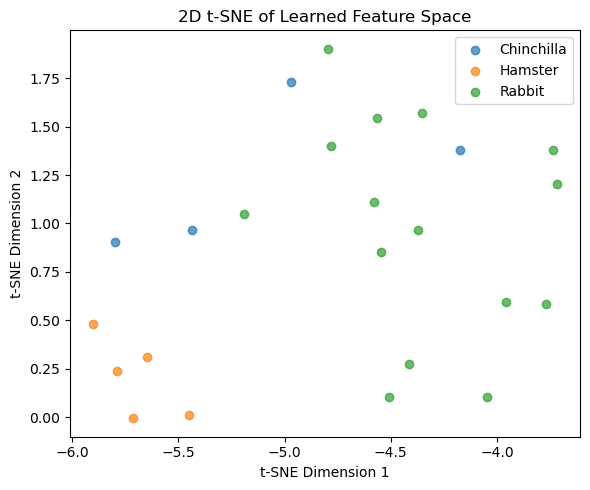

In [277]:
# Plot the 2D features with matplotlib
plt.figure(figsize=(6,5))
# We assume dataset.class_to_idx gives mapping like {'rabbits':0, 'hamsters':1, 'chinchillas':2}
classes = x_raw.classes  # list of class names in order
for class_idx, class_name in enumerate(classes):
    pts = features_2d[all_labels == class_idx]
    plt.scatter(pts[:,0], pts[:,1], label=class_name, alpha=0.7)
plt.legend()
plt.title("2D t-SNE of Learned Feature Space")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.tight_layout()
plt.savefig("feature_space_clusters.png")
plt.show()